In [1]:
from pyluos import Device

In [2]:
import time

In [3]:
import numpy as np

In [4]:
from svgpathtools import svg2paths, wsvg

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
robot = Device('/dev/cu.usbserial-D307RR2E')

In [7]:
robot.modules

-------------------------------------------------
Type                Alias               ID   
-------------------------------------------------
Gate                gate                1    
DynamixelMotor      dxl_2               2    
DynamixelMotor      dxl_12              3    
DynamixelMotor      dxl_30              4    

In [8]:
motor_1 = robot.dxl_12
motor_2 = robot.dxl_30

In [9]:
motor_1.positionPid = [100, 0, 0]

In [10]:
def land():
    robot.dxl_2.target_rot_position = 90
    
def rise():
    robot.dxl_2.target_rot_position = -10

In [11]:
for _ in range(3):
    rise()
    time.sleep(0.5)
    land()
    time.sleep(0.5)

In [12]:
def get_pos():
    return [motor_1.rot_position, motor_2.rot_position]

In [13]:
def compliant():
    motor_1.compliant = True
    motor_2.compliant = True

In [14]:
from __future__ import division

from angles import normalize
from operator import itemgetter
from math import sqrt, acos, cos, sin, asin
from numpy import deg2rad, rad2deg, isclose, array

""" See http://forum.pollen-robotics.com/t/low-cost-multiped-robot/59/11 """

# In mm
d = 27.5
r = 30
L = 50


class LegKinematic(object):
    def forward(self, p1, p2):
        theta1, theta2 = deg2rad(p1), deg2rad(p2)

        x1 = -r * sin(theta1) + d
        y1 = r * cos(theta1)

        x2 = -r * sin(theta2) - d
        y2 = r * cos(theta2)

        sol = (same_radius_circle_intersection((x1, y1), (x2, y2)))
        return max(sol, key=itemgetter(1))

    def inverse(self, x, y):
        C1 = (d, 0)
        C2 = (-d, 0)

        # theta1
        sol_1 = compute_cercle_intersect(C1[0], C1[1], x, y, r, L)
        sol_2 = compute_cercle_intersect(C2[0], C2[1], x, y, r, L)

        sol_1 = max(sol_1, key=itemgetter(0))
        sol_2 = min(sol_2, key=itemgetter(0))

        ratio = (sol_1[0] - C1[0]) / r
        ratio = min(max(ratio, -1.0), 1.0)
        theta1 = rad2deg(asin(ratio))
        theta1 = theta1 if sol_1[1] > 0 else 180 - theta1
        theta1 = normalize(theta1, -180, 180)

        ratio = (sol_2[0] - C2[0]) / r
        ratio = min(max(ratio, -1.0), 1.0)
        theta2 = rad2deg(asin(ratio))
        theta2 = theta2 if sol_2[1] > 0 else 180 - theta2
        theta2 = normalize(theta2, -180, 180)

        return -theta1, -theta2


def valid_motor_position(m1, m2):
    test = (m1 < m2 and -130 < m1 < 45 and -45 < m2 < 130)
    return test


def compute_cercle_intersect(x0, y0, x1, y1, r0, r1):
    d = sqrt((x0 - x1)**2 + (y0 - y1)**2)

    if d > (r0 + r1):
        return []

    a = (r0**2 - r1**2 + d**2) / (2 * d)
    h = sqrt(r0**2 - a**2)

    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d

    xr = h * (y1 - y0) / d
    yr = h * (x1 - x0) / d

    sol = (x2 + xr, y2 + yr), (x2 - xr, y2 - yr), (x2 + xr, y2 - yr), (x2 - xr, y2 + yr)
    good_sol = [s for s in sol if test_r(x0, y0, x1, y1, r0, r1, s)]

    # phi = [rad2deg(compute_phi(x0, y0, x1, y1, r0, r1, good_sol[i]))
    #        for i in range(len(good_sol))]

    return good_sol


def test_r(x0, y0, x1, y1, r0, r1, s):
    test_r0 = sqrt((x0 - s[0])**2 + (y0 - s[1])**2)
    test_r1 = sqrt((x1 - s[0])**2 + (y1 - s[1])**2)

    return isclose(test_r0, r0) and isclose(test_r1, r1)


def compute_phi(x0, y0, x1, y1, r0, r1, s):
    u = array([x0 - s[0], y0 - s[1]])
    v = array([x1 - s[0], y1 - s[1]])
    c_phi = u.dot(v) / (r0 * r1)

    return acos(c_phi)


def same_radius_circle_intersection(c1, c2):
    (x1, y1), (x2, y2) = c1, c2
    R = sqrt((x2 - x1)**2 + (y2 - y1)**2)

    xl = 0.5 * (x1 + x2)
    xr = 0.5 * sqrt(2 * ((L**2 + L**2) / (R**2)) - 1) * (y2 - y1)
    yl = 0.5 * (y1 + y2)
    yr = 0.5 * sqrt(2 * ((L**2 + L**2) / (R**2)) - 1) * (x1 - x2)

    return (xl + xr, yl + yr), (xl - xr, yl - yr)

In [15]:
def trace_path(path, n_eval=100):
    pos = np.asarray([[np.real(path.point(x)), np.imag(path.point(x))] for x in np.linspace(1,0,n_eval)])
    
    return pos[:,0], -1*pos[:,1]

In [16]:
compliant()

In [89]:
paths, attributes = svg2paths('/Users/matthieulapeyre/Downloads/bar.svg')
DPI = 144

In [90]:
def pixel2mm(pix,DPI=144):
    return pix * 25.4 / DPI

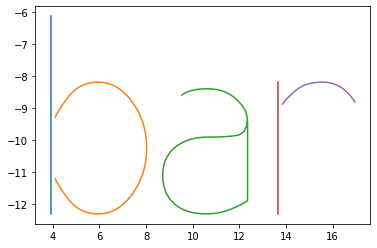

In [91]:
plt.figure()

for p in paths:
    pts = np.asarray([[np.real(p.point(x)), np.imag(p.point(x))] for x in np.linspace(1,0,60)])
    plt.plot(pixel2mm(pts[:,0]), -1*pixel2mm(pts[:,1]))

plt.show()

In [84]:
hand = LegKinematic()

In [85]:
y_max = 65
y_min = 35
x_min = -25
x_max = 30

In [86]:
x,y = trace_path(paths[0])
y_offset = y_min - min(pixel2mm(y))

In [87]:
paths[0].length()/4

116.63009722351856

In [88]:
rise()
for p in paths:   
    x,y = trace_path(p, int(p.length()/4))

    x = pixel2mm(x)
    y = pixel2mm(y)

    scale = 50
    first = True

    for i in range(len(x)):
        try:
            p1,p2 = hand.inverse(x[i], y[i]+ y_offset)

            motor_1.target_rot_position = p1
            motor_2.target_rot_position = p2

            if first:
                time.sleep(0.5)
                land()
                first = False
                time.sleep(0.5)

            time.sleep(0.03)
        except:
            pass
    
    rise()
    time.sleep(0.5)

land()

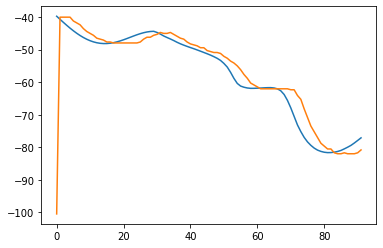

In [107]:

plt.plot(np.asarray(goal)[:,0])
plt.plot(np.asarray(present)[:,0])

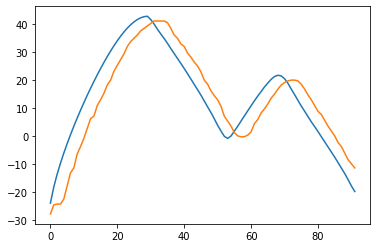

In [108]:
plt.plot(np.asarray(goal)[:,1])
plt.plot(np.asarray(present)[:,1])

In [112]:

fg = []
for g in goal:
    fg.append(hand.forward(g[0], g[1]))
fg = np.array(fg)

fp = []
for p in present:
    fp.append(hand.forward(p[0], p[1]))
fp = np.array(fp)


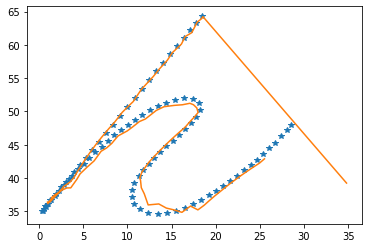

In [113]:
plt.plot(fg[:,0], fg[:,1], '*')
plt.plot(fp[:,0], fp[:,1])

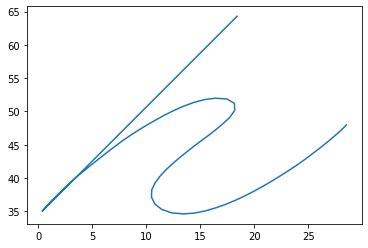

In [172]:
land()

In [173]:
rise()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/matthieulapeyre/.virtualenvs/reachy/lib/python3.8/site-packages/pyluos/io/serial_io.py", line 89, in _poll
    to_read = self._serial.in_waiting
  File "/Users/matthieulapeyre/.virtualenvs/reachy/lib/python3.8/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured


In [24]:
compliant()

In [34]:
pos = []
while True:
    pos.append(get_pos())
    time.sleep(0.2)

KeyboardInterrupt: 

In [35]:
land()
for p in pos:
    robot.dxl_12.target_rot_position = p[0]
    robot.dxl_30.target_rot_position = p[1]
    time.sleep(0.2)

rise()

In [17]:
rise()

In [38]:
hand.forward(d.dxl_12.rot_position, d.dxl_30.rot_position)

AttributeError: 'float' object has no attribute 'dxl_12'